 # EDA 3

I transformed the original dataset into a new format suitable for analysis by applying the following transformations: The `order_id` column was kept as is. The `pnr` column was replaced by `pnr_size`, which stores the count of components in the original value, split by commas. The `booking_system`, `brand`, and `partner` columns were stripped of prefixes ("System ", "Brand ", "Partner ") and any leading or trailing whitespace. The `currency` column was mapped to standardized abbreviations (e.g., "Euro" to "EUR") using a predefined dictionary, and the `order_amount` column was converted to US dollars using conversion rates stored in another predefined dictionary (I used an average value for 2024). The `order_amount` values were then rounded to two decimal places. The `order_created_at` column was decomposed into `weekday`, representing the day of the week, and `time_slot`, categorizing time into predefined intervals of six hours. A new boolean column, `zero_errands`, was added to indicate whether the `count_errands` column had a value of zero. All other specified columns were copied without changes, and any unspecified columns were dropped. This ensures the dataset retains the necessary structure and types for subsequent analysis.

In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

DF_FRAC = 0.25
SEED = 42
TEST_SIZE = 0.2

In [2]:
# Load the dataset
df = pd.read_parquet("data/orders_ml.parquet")
if DF_FRAC < 1:
    df = df.sample(frac=DF_FRAC, random_state=SEED).reset_index(drop=True)

# Drop target columns and columns correlated with them from X
X = df.drop(
    columns=[
        "count_errands",
        "zero_errands",
        "order_id",
        "change_reason",
        "cancel_reason",
        "is_canceled",
        "is_changed",
    ]
)
y_boolean = df["zero_errands"]
y_numeric = df["count_errands"]

In [3]:
# Identify categorical and numeric features
categorical_features = X.select_dtypes(include=["object", "category"]).columns
numeric_features = [col for col in X.columns if col not in categorical_features]

# Split the data
X_train, X_test, y_boolean_train, y_boolean_test, y_numeric_train, y_numeric_test = (
    train_test_split(X, y_boolean, y_numeric, test_size=TEST_SIZE, random_state=SEED)
)

In [4]:
# One-Hot Encoding for Logistic Regression with Handling for Unknown Categories
# Combine train and test to extract all categories
all_categories = {
    col: np.union1d(
        X_train[col].unique(), X_test[col].unique()
    )  # Union of train and test categories
    for col in categorical_features
}

# Define the column transformer with explicit categories
one_hot_encoder = ColumnTransformer(
    transformers=[
        (
            "onehot",
            OneHotEncoder(
                categories=[all_categories[col] for col in categorical_features],
                handle_unknown="ignore",  # Ignore unknown categories during transform
                drop="first",
            ),
            categorical_features,
        )
    ],
    remainder="passthrough",  # Keep numeric columns as-is
)

# Apply one-hot encoding
X_train_encoded = one_hot_encoder.fit_transform(X_train)
X_test_encoded = one_hot_encoder.transform(X_test)

# Convert back to DataFrame for interpretability
encoded_feature_names = one_hot_encoder.get_feature_names_out()
X_train_encoded = pd.DataFrame(X_train_encoded.toarray(), columns=encoded_feature_names)
X_test_encoded = pd.DataFrame(X_test_encoded.toarray(), columns=encoded_feature_names)

# Step: Scale all features (including one-hot encoded ones)
scaler = StandardScaler()
X_train_encoded = scaler.fit_transform(X_train_encoded)
X_test_encoded = scaler.transform(X_test_encoded)

In [5]:
# Train Logistic Regression
log_reg = LogisticRegression(random_state=SEED, max_iter=500)
log_reg.fit(X_train_encoded, y_boolean_train)

# Logistic Regression Coefficients and Odds Ratios
log_odds = pd.DataFrame(
    {
        "Feature": encoded_feature_names,
        "Coefficient": log_reg.coef_[0],
        "Odds Ratio": np.exp(log_reg.coef_[0]),
    }
)
log_odds.sort_values(by="Odds Ratio", ascending=False, inplace=True)

print("Logistic Regression Insights (Odds Ratios):")
print(log_odds)

Logistic Regression Insights (Odds Ratios):
                                           Feature  Coefficient  Odds Ratio
478                onehot__journey_type_id_One-way     0.406612    1.501721
482             onehot__journey_type_id_Round-trip     0.157125    1.170142
378             onehot__customer_group_type_SINGLE     0.081270    1.084663
79                        onehot__booking_system_C     0.054456    1.055966
343                           onehot__currency_EUR     0.052391    1.053788
..                                             ...          ...         ...
402         onehot__booking_system_source_type_NDC    -0.056034    0.945507
404  onehot__booking_system_source_type_Web scrape    -0.061801    0.940070
376             onehot__customer_group_type_FAMILY    -0.074308    0.928386
400         onehot__booking_system_source_type_GDS    -0.075733    0.927063
492                            remainder__pnr_size    -0.203337    0.816003

[494 rows x 3 columns]


In [6]:
# Random Forest with Integer Encoding
# Integer encoding for categorical features (already done for random forest)
for col in categorical_features:
    cat_type = pd.CategoricalDtype(categories=X_train[col].unique(), ordered=False)
    X_train[col] = X_train[col].astype(cat_type).cat.codes
    X_test[col] = X_test[col].astype(cat_type).cat.codes

# Train random forest on the original integer-encoded data
rf_clf = RandomForestClassifier(random_state=SEED)
rf_clf.fit(X_train, y_boolean_train)

# Random Forest Feature Importance
rf_importance = pd.DataFrame(
    {
        "Feature": X_train.columns,
        "Importance": rf_clf.feature_importances_,
    }
)
rf_importance["Percentage Contribution"] = (
    rf_importance["Importance"] / rf_importance["Importance"].sum()
) * 100
rf_importance.sort_values(by="Importance", ascending=False, inplace=True)

print("\nRandom Forest Feature Importance:")
print(rf_importance)


Random Forest Feature Importance:
                       Feature  Importance  Percentage Contribution
5                 order_amount    0.470765                47.076500
12                     weekday    0.121275                12.127536
13                   time_slot    0.062629                 6.262919
10              origin_country    0.057219                 5.721925
7                       device    0.055933                 5.593295
1               booking_system    0.053857                 5.385724
3                      partner    0.036382                 3.638193
6          customer_group_type    0.034957                 3.495731
2                        brand    0.033392                 3.339164
4                     currency    0.024380                 2.437984
9   booking_system_source_type    0.019737                 1.973694
11             journey_type_id    0.012679                 1.267910
8            client_entry_type    0.009162                 0.916168
0            

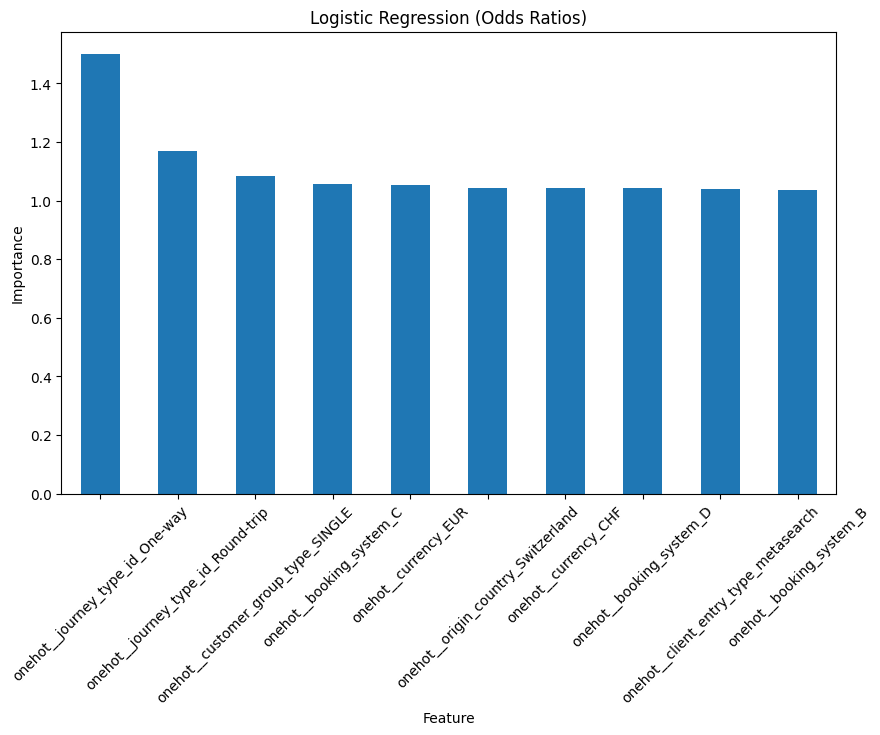

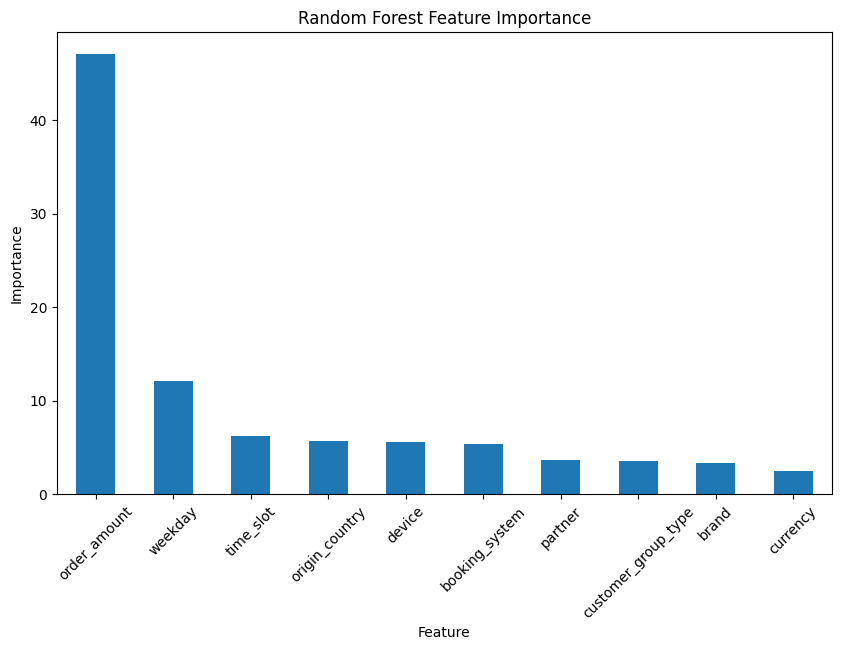

In [7]:
# Visualization
def plot_feature_importances(importances, title):
    sorted_importances = importances.sort_values(
        ascending=False
    )  # Create a sorted copy
    plt.figure(figsize=(10, 6))
    sorted_importances.head(10).plot(kind="bar")
    plt.title(title)
    plt.ylabel("Importance")
    plt.xticks(rotation=45)
    plt.show()


# Visualize binary classification importances
plot_feature_importances(
    log_odds.set_index("Feature")["Odds Ratio"], "Logistic Regression (Odds Ratios)"
)
plot_feature_importances(
    rf_importance.set_index("Feature")["Percentage Contribution"],
    "Random Forest Feature Importance",
)

In [8]:
# Step 5: Summary Outputs
binary_auc_log_reg = roc_auc_score(
    y_boolean_test, log_reg.predict_proba(X_test_encoded)[:, 1]
)
binary_auc_rf_clf = roc_auc_score(y_boolean_test, rf_clf.predict_proba(X_test)[:, 1])

print(f"\nLogistic Regression AUC (Binary): {binary_auc_log_reg:.4f}")
print(f"Random Forest AUC (Binary): {binary_auc_rf_clf:.4f}")


Logistic Regression AUC (Binary): 0.6165
Random Forest AUC (Binary): 0.5858
